In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import make_scorer, precision_recall_fscore_support


In [ ]:
dataset = pd.read_csv('clean_dataset.csv')
dataset.head(20)

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.250,1,1,1,0,ByBirth,202,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.040,1,1,6,0,ByBirth,43,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.500,1,0,0,0,ByBirth,280,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.750,1,1,5,1,ByBirth,100,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.710,1,0,0,0,ByOtherMeans,120,0,1
5,1,32.08,4.000,1,1,CommunicationServices,White,2.500,1,0,0,1,ByBirth,360,0,1
6,1,33.17,1.040,1,1,Transport,Black,6.500,1,0,0,1,ByBirth,164,31285,1
7,0,22.92,11.585,1,1,InformationTechnology,White,0.040,1,0,0,0,ByBirth,80,1349,1
8,1,54.42,0.500,0,0,Financials,Black,3.960,1,0,0,0,ByBirth,180,314,1
9,1,42.50,4.915,0,0,Industrials,White,3.165,1,0,0,1,ByBirth,52,1442,1


In [ ]:
dataset['Income_YearsEmployed'] = dataset['Income'] * dataset['YearsEmployed']
dataset['Debt_to_Income'] = dataset['Debt'] / (dataset['Income'] + 1e-6)

dataset['Age_Group'] = pd.cut(dataset['Age'], bins=[0, 30, 60, np.inf], labels=['Young', 'Middle-aged', 'Senior'])

dataset['High_CreditScore'] = (dataset['CreditScore'] > 5).astype(int)

dataset = dataset.drop(columns=['ZipCode'])
categorical_features = ['Industry', 'Ethnicity', 'Citizen', 'Age_Group']
numerical_features = ['Age', 'Debt', 'YearsEmployed', 'Income', 'Income_YearsEmployed', 'Debt_to_Income']

X = dataset.drop(columns=['Approved'])
y = dataset['Approved']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Baseline Model

In [ ]:
negative = np.sum(y_train == 0)
positive = np.sum(y_train == 1)
print(pd.Series({'0': negative, '1': positive}))

0    306
1    246
dtype: int64


In [ ]:
baseline = np.zeros(len(y_test))
cmbase = confusion_matrix(y_test, baseline)
accbase = (cmbase.ravel()[0]+cmbase.ravel()[3])/sum(cmbase.ravel())
accbase

0.5579710144927537

# Classification Tree Model

In [ ]:
# Use CV to find optimal hyperparameters (ccp_alpha)
grid_values = {'ccp_alpha': np.linspace(0, 0.1, 201)}

dtccv = DecisionTreeClassifier()

dtc_cv_acc = GridSearchCV(dtccv, param_grid = grid_values, scoring = 'f1', cv=10, verbose=1)
dtc_cv_acc.fit(X_train_processed, y_train)

Fitting 10 folds for each of 201 candidates, totalling 2010 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195,
       0.02  , 0.02...
       0.072 , 0.0725, 0.073 , 0.0735, 0.074 , 0.0745, 0.075 , 0.0755,
       0.076 , 0.0765, 0.077 , 0.0775, 0.078 , 0.0785, 0.079 , 0.0795,
       0.08  , 0.0805, 0.081 , 0.0815, 0.082 , 0.0825, 0.083 , 0.0835,
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ])},
             scoring='f1', verbose=1)

Node count = 11


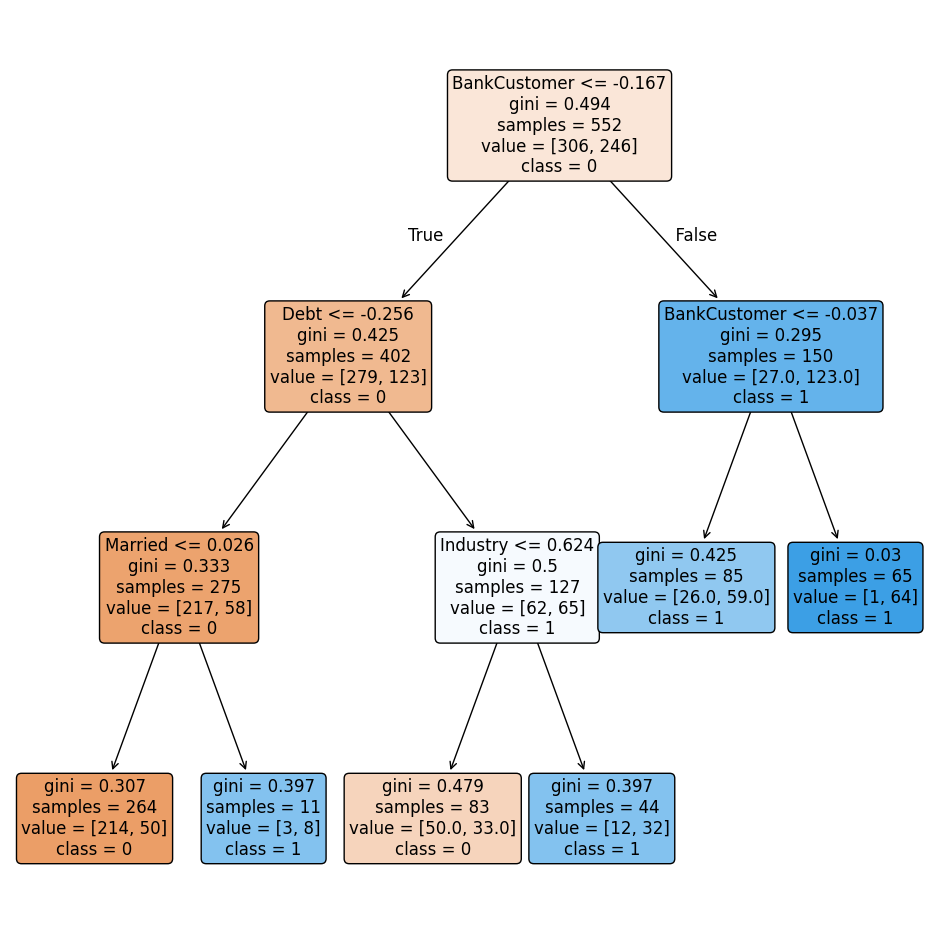

In [ ]:
# Fit CART model, make predictions
dtc = DecisionTreeClassifier(
                             ccp_alpha=0.01,
                             random_state = 88)

dtc = dtc.fit(X_train_processed, y_train)
print('Node count =', dtc.tree_.node_count)
plt.figure(figsize=(12,12))
plot_tree(dtc,
          feature_names=X_train.columns,
          class_names=['0','1'],
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12)
plt.show()

In [ ]:
# Predict Accuracy
y_pred_cart = dtc.predict(X_test_processed)
cmcart = confusion_matrix(y_test, y_pred_cart)
acccart = (cmcart.ravel()[0]+cmcart.ravel()[3])/sum(cmcart.ravel())
acccart

0.7681159420289855

In [ ]:
# Predict CART MAE
cartmae = np.mean(abs(y_pred_cart - y_test))
# Predict CART MSE
cartmse = np.mean((y_pred_cart - y_test)**2)
# Predict CART RMSE
cartrmse = np.sqrt(np.mean((y_pred_cart - y_test)**2))
# Predict CART OSR2
cartosr2 = r2_score(y_test, y_pred_cart)

print(f"CART MAE: {cartmae}")
print(f"CART MSE: {cartmse}")
print(f"CART RMSE: {cartrmse}")
print(f"CART OSR²: {cartosr2}")
print("CART ROC-AUC Score:", roc_auc_score(y_test, y_pred_cart))
print("CART Classification Report:")
print(classification_report(y_test, y_pred_cart))

CART MAE: 0.2318840579710145
CART MSE: 0.2318840579710145
CART RMSE: 0.4815434123430768
CART OSR²: 0.05982542048115835
CART ROC-AUC Score: 0.754737066212476
CART Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.81        77
           1       0.80      0.64      0.71        61

    accuracy                           0.77       138
   macro avg       0.77      0.75      0.76       138
weighted avg       0.77      0.77      0.76       138



# Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf.fit(X_train_processed, y_train)

y_pred = rf.predict(X_test_processed)
y_pred_proba = rf.predict_proba(X_test_processed)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        77
           1       0.71      0.61      0.65        61

    accuracy                           0.72       138
   macro avg       0.72      0.71      0.71       138
weighted avg       0.72      0.72      0.71       138

ROC-AUC Score: 0.7789014264424101
Confusion Matrix:
[[62 15]
 [24 37]]


In [ ]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 2, 5],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_processed, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best ROC-AUC Score:", grid_search.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best ROC-AUC Score: 0.8392241228590855


In [ ]:
final_rf_model = grid_search.best_estimator_

final_rf_model.fit(X_train_processed, y_train)

y_pred = final_rf_model.predict(X_test_processed)
y_pred_proba = final_rf_model.predict_proba(X_test_processed)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

best_rf_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)
cv_scores = cross_val_score(best_rf_model, X_train_processed, y_train, cv=5, scoring='f1')
print("Cross-validated F1-Score:", cv_scores.mean())

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.83      0.77        77
           1       0.73      0.59      0.65        61

    accuracy                           0.72       138
   macro avg       0.73      0.71      0.71       138
weighted avg       0.73      0.72      0.72       138

Confusion Matrix:
[[64 13]
 [25 36]]
Test Accuracy: 0.7246376811594203
Cross-validated F1-Score: 0.6893622938156785


In [ ]:
mae = mean_absolute_error(y_test, y_pred_proba)
print("Random Forest MAE):", mae)

mse = mean_squared_error(y_test, y_pred_proba)
print("Mean Squared Error (MSE):", mse)

osr2 = r2_score(y_test, y_pred_proba)
print("Out-of-Sample R² (OSR²):", osr2)

Random Forest MAE): 0.3566786818101046
Mean Squared Error (MSE): 0.181132611805794
Out-of-Sample R² (OSR²): 0.2655973048265827


In [ ]:
probs = final_rf_model.predict_proba(X_test_processed)[:, 1]

threshold = 0.4
y_pred_threshold = (probs >= threshold).astype(int)

print("Classification Report (Threshold = 0.4):")
print(classification_report(y_test, y_pred_threshold))


Classification Report (Threshold = 0.4):
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        77
           1       0.71      0.74      0.73        61

    accuracy                           0.75       138
   macro avg       0.75      0.75      0.75       138
weighted avg       0.75      0.75      0.75       138



In [ ]:
def threshold_scorer(y_true, y_pred_proba, threshold=0.4):
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_threshold, average='binary')
    return f1

scorer = make_scorer(threshold_scorer, needs_proba=True)

cv_scores = cross_val_score(final_rf_model, X_train_processed, y_train, cv=5, scoring=scorer)

print("Cross-Validated F1-Score with Adjusted Threshold (0.4):", np.mean(cv_scores))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Cross-Validated F1-Score with Adjusted Threshold (0.4): 0.7432848681369743


# Logistic Regression

In [ ]:
# Initialize and train the logistic regression model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train_processed, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test_processed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display the evaluation results
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Accuracy: 0.7391304347826086

Confusion Matrix:
 [[65 12]
 [24 37]]

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.84      0.78        77
           1       0.76      0.61      0.67        61

    accuracy                           0.74       138
   macro avg       0.74      0.73      0.73       138
weighted avg       0.74      0.74      0.73       138



In [ ]:
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate OSR^2
ss_residual = np.sum((y_test - y_pred) ** 2)
ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
osr2 = 1 - (ss_residual / ss_total)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"OSR²: {osr2}")
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

MAE: 0.2608695652173913
MSE: 0.2608695652173913
RMSE: 0.5107539184552492
OSR²: -0.05769640195869696
ROC-AUC Score: 0.7949755162869917
